# 6장 의사결정나무

## 핵심 주제

1. 의사결정나무 훈련과 시각화
1. 예측과 지니 불순도
1. CART 훈련 알고리즘과 계산 복잡도
1. 지니 불순도 대 엔트로피
1. 의사결정나무 훈련 규제
1. 의사결정나무와 회귀
1. 의사결정나무의 단점

## 파이썬 기본 설정

* 파이선 버전 3.5 이상
* 사이킷런 버전 0.20 이상
* 모듈 불러오기
    * numpy
    * matplotlib
    * matplotlib.pyplot
* 그림 저장 위치 지정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 핵심 1: 의사결정나무 훈련과 시각화 

붓꽃 데이터를 이용하여 의사결정나무 모델을 훈련시키고 예측하는 방법을 설명한다. 

### 의사결정나무 훈련

아래 코드는 `DecisionTreeClassifier` 분류기를 이용하여 붗꼿을 
꽃잎의 길이와 너비 기준으로 분류하는 훈련과정을 실행한다.
의사결정나무 방식의 최대 장점은 **데이터 전처리 불필요**이다.
아래 의사결정나무 분류기에 사요된 옵션은 다음과 같다.

* `max_depth`: 의사결정나무의 최대 깊이 지정. 여기서는 2 사용. 
    즉, 연속된 가지치기는 최대 2번까기 가능하다.

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # 꽃잎 길이와 너비
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

### 시각화

아래 코드는 훈련 결과를 이미지로 보여준다. 

* `export_graphviz()` 함수
    * 훈련 결과를 그래프 정보로 변환한 후 `iris_tree.dot` 파일에 저장
* `Source` 클래스의 `from_file()` 클래스 메서드
    * dot 파일에 저장된 그래프를 직접 주피터 노트북에 보여줄 때 사용.
    
`max_depth=2` 이였기 때문에 깊이가 최대 2인 의사결정나무가 생성된다.

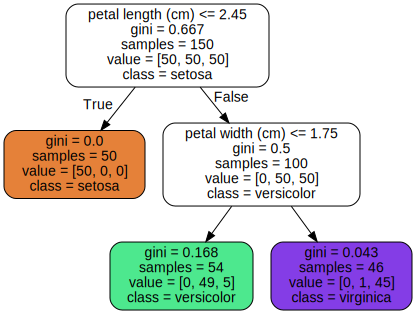

In [3]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

### 나무 구성 요소

나무(tree)의 기본 구성요소는 다음과 같다.

* 마디(node): 가지치기가 시작되는 지점.
* 뿌리 마디(root node): 맨 상단에 위치한 마디. 즉, 가지치기가 시작하는 지점의 마디.
* 나뭇잎(leaf node): 더 이상의 가기치기가 발생하지 않는 마디.

**주의**: 책에서는 마디, 뿌리 마디, 나뭇잎을 각각 노드, 루트 노드, 리프 노드로 표현했다.
또한 의사결정나무를 결정 트리로 표현했다. 
하지만 여기서 사용하는 용어가 통계학 분야에서 일반적으로 사용되는 표현이다.

## 핵심 2: 예측과 지니 불순도

훈련 결과를 이용하여 어떻게 예측하는지를 예를 이용하여 살펴보자.
데이터가 주어지면 뿌리 마디(맨 위에 위치한 마디)에서 시작한다.

* 꽃잎 길이가 2.45cm 이하
    - 뿌리 마디에서 시작하여 왼편으로 이동. setosa 품종으로 결론
* 꽃잎 길이 2.45 초과
    - 뿌리 마디에서 시작하여 오른편으로 이동. 
    - 꽃잎 너비가 1.75 이하
        + 왼편으로 이동. versicolor 품종으로 결론
    - 꽃 너비가 1.75 초과
        + 오른편으로 이동. virginica 품종으로 결론    

### 의사결정나무 마디 속성

의사결정나무 마디(node)에 포함된 속성은 다음과 같다.

* `samples`: 해당 마디 결정에 사용된 샘플 수
* `value`: 해당 마디 결정에 사용된 샘플을 클래스 별로 구분한 결과. 
    훈련 샘플의 레이블 정보를 이용하여 분류.
* `class`: 각 클래스별 비율을 계산하여 가장 높은 비율에 해당하는 클래스 선정.
    동일한 비율이면 낮은 인덱스 선정.
    예를 들어, 깊이 2의 왼편 마디의 클래스별 비율은 다음과 같다.
    <br><br>
$$p_0= 0/54, \quad p_1=49/54, \quad p_2 = 5/54$$    

앞서 계산한 클래스별 비율은 `predict_proba()` 메서드가 주어진 샘플이 속하는 잎에서의 확률로 사용한다. 
예를 들어, 아래 코드는 꽃잎 길이와 너비가 각각 5cm, 1.5cm인 붓꽃에 대한 예측 확률과 클래스를 계산하는데,
앞서 계산한 클래스 별 비율과 일치한다.

In [4]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

`predict()` 메서드는 이 결과를 이용하여 소속 클래스를 예측한다.
꽃잎 길이와 너비가 각각 5cm, 1.5cm 꽃잎에 대한 예측값은 1번 클래스인 Versicolor 품종이다.

In [5]:
tree_clf.predict([[5, 1.5]])

array([1])

동일한 마디에 속한 샘플에 대한 예측값은 언제나 동일하다. 
이유는 앞서 설명한대로 예측값이 전적으로 해당 마디의 클래스별 비율에 의해 결정되기 때문이다. 

### 지니 불순도

마디에 포함된 `gini` 속성은 해당 마디의 **지니 불순도**(impurity)를 가리키며,
다음과 같이 계산된다.

$$G = 1 - \sum_{k=0}^{K-1} p_{k}^2$$

여기서, $K$는 클래스 수이고, $p_k$는 클래스 $k$에 속한 샘플의 비율임.
예를 들어, 깊이 2의 왼편 마디의 지니 불순도는 다음과 
같이 0.168임.

$$G = 1 - (0/54)^2 - (49/54)^2 - (5/54)^2 = 0.168$$

### 의사결정나무의 결정 경계

아래 코드는 의사결정나무를 다른 방식으로 보여준다.
마디를 구분하는 결정 경계가 표시되었으며, 결정 경계에 대한 정보는 
앞서 의사결정나무에서 사용된 기준을 사용한다. 

아래 코드에 정의된 `plot_decision_boundary()` 함수는 
결정 경계를 그래프로 그리는 기능을 제공한다.

In [6]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

그림 저장: decision_tree_decision_boundaries_plot


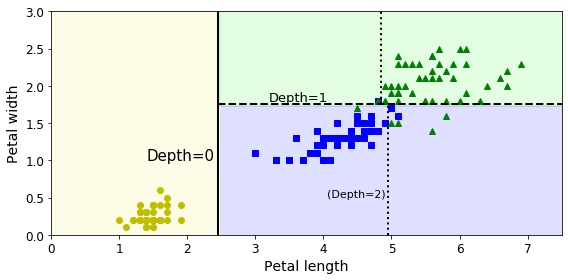

In [7]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

위 그래프에서 사용된 결정 경계는 다음 정보에서 얻어진다. 

* Depth=0(깊이=0)
    * 뿌리 마디에서의 결정 경계
    * `petal lengh(cm) <= 2.45`에 해당
* Depth=1(깊이=1)
    * 깊이 1의 오른편 마디에서의 결정 경계
    * `petal width(cm) <= 1.75`에 해당
* Depth=2(깊이=2)
    * 깊이 2의 두 마디에서의 결정 경계
    * 아랫쪽: `petal width(cm) <= 4.95`에 해당
    * 윗쪽: `petal width(cm) <= 4.85`에 해당    
    
(깊이 2)의 경우 앞서 구한 의사결정나무가 아니라 `max_depth=3`으로 지정했을 때 얻어지는 결과를 이용한 것이다.
실제로 아래와 같이 실행하면 깊이 2의 마디에서 각각 꽃잎 길이 4.95와 4.85기준으로
다시 한 번 분류되었음을 확인할 수 있다. 

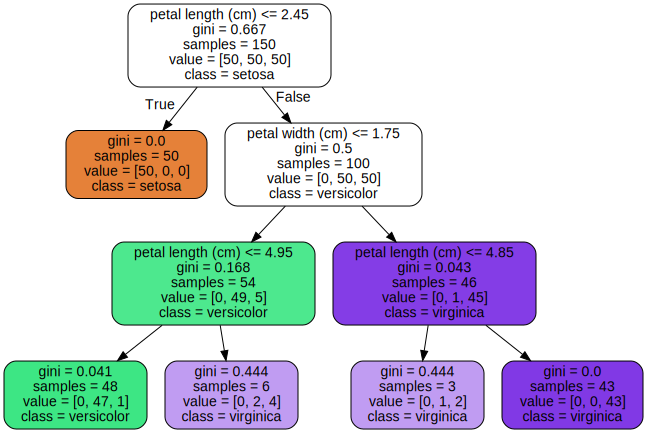

In [8]:
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X, y)

from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

새로 생성된 잎에서도 지니 불순도가 여전히 0이 아닌 경우가 발생한다. 
아마도 `max_depth=4`로 지정하면 지니 불순도가 0인 잎의 비율이 증가할 것이다.
하지만 `max_depth` 값을 키우면 과대적합의 위험도 또한 증가함에 주의해야 한다. 
실제로 `max_depth`를 모델 학습을 규제하기 위한 주요 수단으로 사용한다.

## 핵심 3: CART 훈련 알고리즘과 계산 복잡도

### CART 훈련 알고리즘

사이킷런은 CART(classification and regression tree, 분류와 회귀 나무) 알고리즘을 이용하여
의사결정나무를 훈련시킨다. 
CART 알고리즘의 작동법은 다음과 같다.

* 탐욕적 알고리즘(greedy algorithm)을 이용하여 아래 비용함수를 최소화 하는
    특성 $k$와 해당 특성의 임곗값 $t_k$을 결정한다. 
    <br><br>
$$
J(k, t_k) = \frac{m_\text{left}}{m}\, G_\text{left} + \frac{m_\text{right}}{m}\, G_\text{right}
$$
    <br>
    여기서

    * $G_\text{left}$($G_\text{right}$)는 왼편(오른편) 부분집합의 지니 불순도
    * $m_\text{left}$($m_\text{right}$)는 왼편(오른편) 부분집합의 샘플 수
    
* $J(k, t_k)$이 작을 수록 지니 불순도가 보다 낮은 두 개의 부분집합으로 분할할 수 있게 된다.
    따라서 탐욕적 알고리즘은 해당 마디에 포함된 샘플을 지니 불순도가 가장 낮은, 즉, 가장 순수한(pure)
    두 개의 부분집압으로 분할한다.
* 이렇게 나누는 과정은 `max_depth` 깊이에 다다르거나 불순도를 줄이는 분할을 더 이상 찾을 수 없을 때,
    또는 다른 규제의 한계에 다다를 때 까지 반복된다.
    규제에 대해서는 바로 이어서 좀 더 자세히 설명한다.

### 계산 복잡도

CART 알고리즘에서 사용하는 탐욕적 알고리즘은 반복적으로 사용되었을 때 최적화된 의사결정나무를 생성한다는 보장은 없다. 
하지만 종종 충분히 좋은 결과를 생산한다. 

불행히도 최적의 의사결정나무를 찾는 문제는 NP-완전(NP-complete)로 알려져 있다. 
이런 문제의 시간 복잡도는 $O(\exp(m))$ 이며, 따라서 매우 작은 훈련 세트에 대해서도 
제대로 적용하기 어렵다. 

**참조**: NP-완전 문제에 대한 설명은 이 책의 내용을 벗어난다. 
여기서는 시간 복잡도가 매우 커서 실용적으로 사용할 수 없다는 의미로 받아들이면 된다.

반면에
사이킷런의 의사결정트리에 사용된 알고리즘의 복잡도는 (샘플을 미리 퀵정렬 시켰다고 가정했을 때)
각 마디에서는 $O(n\cdot m\, \log(m))$ 이며, 
아무런 규제가 없다면 의사결정나무를 완성하는 데 걸리는 시간은
대략 $O(n\cdot m^2\, \log(m))$ 이다.
여기서 $n$은 특성 수, $m$은 샘플 수를 가리킨다.
(참조: [사이킷런 의사결정나무](https://scikit-learn.org/stable/modules/tree.html#complexity))

훈련 세트를 미리 퀵정렬 시키려면 `presort=True` 옵션을 이용하념 된다. 
하지만 훈련 세트가 크면 이 방식은 속도가 늦어진다. 
이유는 퀵정렬 자체의 복잡도가 $O(m\log m)$ 샘플 수가 크면 상당히 느려지기 때문이다.

의사결정나무가 완성이 되었다면, 예측에 필요한 시간은 보통 특성 수와 상관없이 $O(\log m)$으로 매우 빠르다. 

## 핵심 4: 지니 불순도 대 엔트로피

사이킷런의 의사결정나무 알고리즘은 기본적으로 지니 불순도를 기준으로 분할된 부분집합의 불순도를 측정한다.
즉, `criterion="gini"`가 기본값이다. 
반면에 엔트로피를 사용하려면 `criterion="entropy"` 로 지정해야 한다. 
특정 마디의 엔트로피($H$) 계산은 다음과 같다. 

$$H = -\sum_{\substack{k=0\\p_k\neq 0}}^{K-1} p_{k}\, \log(p_k)$$

* 두 불순도의 차이는 크지 않으며, 비슷한 의사결정나무를 생성한다.
* 반면에 엔트로피 불순도가 좀 더 균형잡힌 이진나무(balanced binary tree)를 생성한다.
    이유는 $p_k$ 가 특정 $k$ 클래스에 대해 너무 0에 가까우면
    $\log(p_k)$ 는 음의 무한대로 수렴한다. 
    즉, 엔트로피가 증가하여 비용함수 $J(k, t_k)$가 커지게 되어 그런 조합은 피하게 된다.
    따라서 마디를 보다 균형 잡힙 두 개의 부분집합으로 분할하는 방향으로 유도한다. 
    보다 자세한 설명은 [세바스찬 라쉬카의 블로그](https://tensorflow.blog/2018/03/25/결정-트리와-불순도에-대한-궁금증/)를 참조한다.
* 지니 불순도가 좀 더 계산이 빠르기에, 기본값으로 사용한다.

## 핵심 5: 의사결정나무 훈련 규제

#### 비매개변수 모델(nonparametric model)

* 훈련 시작 전에 파라미터 수가 결정되지 않는 모델
* 예제: 의사결정나무. 어떤 모델일지 미리 지정하지 않음.
    * 마디를 분할할 수 있는 자유도(degree of freedom) 제함 없음
* 과대적합 위험 높음

#### 매개변수 모델(parametric model)

* 미리 정의된 모델 파라미터 사용
* 예제: 선형 모델
* 과대적합 위험도 줄어듦. 
* 과소적합 위험도 커딤.

사이킷런 의사결정나무 훈련 알고리즘의 
규제에 사용되는 주요 옵션은 다음과 같다.
* `max_depth`: 의사결정나무의 최대 높이 제한
* `min_samples_split`: 마디에 포함된 최소 샘플 수
* `min_samples_leaf`: 잎에 포함되는 최소 샘플 수
* `min_weight_fraction_leaf`: 샘플 별로 가중치가 있는 경우 가중치의 전체 합에서 해당 잎에 포함된
    샘플의 가중치의 합에 차지하는 비율. 가중치가 설정되지 않았다면 모두 동일한 가중치를 가졌다고 가정함.
    이런 경우 `min_samples_leaf`와 동일한 역할 수행.
* `max_leaf_nodes`: 잎의 최대 수
* `max_features`: 각 마디에서 분할 평가에 사용될 수 있는 특성 수
    
규제를 높이는 방법은 기본적으로 다음과 같다.

* `min` 접두사 사용 규제: 규제 값을 키운다.
* `max` 접두사 사용 규제: 규제 값을 줄인다.

아래 코드는 규제가 전혀 없는 모델과 `min_samples_leaf=4` 규제를 사용하는 모델의 차이를 보여준다. 
규제를 전혀 사용하지 않는 왼편 모델의 그래프가 훨씬 정교하게 클래스를 분류한다.

그림 저장: min_samples_leaf_plot


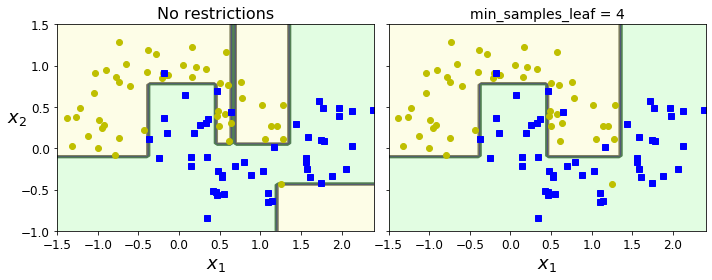

In [9]:
from sklearn.datasets import make_moons

# moons 데이터셋 사용
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

# 규제 없는 모델
deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
# 규제 있는 모델
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
# 모델 훈련하기
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

# 그래프 그리기
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

# 왼편 그래프: 규제 없는 모델
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)

# 오른편 그래프: 규제 있는 모델
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

save_fig("min_samples_leaf_plot")
plt.show()

#### 사전 가지치기 대 사후 가지치기

사이킷런의 `DecisionTreeClassifier` 처럼 학습 과정에 사용되는 규제에 따라
분할을 제한하는 것을 **사전 가지치기**라 부른다.
반면에 우선 제한 없이 의사결정나무를 훈련 시킨 뒤에 통계적 가설검정을 이용하여
별로 의미 없는 마디를 잘라내는 기법을 **사후 가지치기**라 부른다.
사이킷런은 사후 가지치기를 지원하지 않는다.

## 핵심 6: 의사결정나무와 회귀

의사결정나무 알고리즘 아이디어를 거의 그대로 이용하여 회귀 문제에 적용할 수 있다.

### 회귀용 의사결정나무 활용법

아래 코드는 사이킷런의 `DecisionTreeRegressor` 예측기를 이용하는 방법을 소개한다.

먼저 가우시안 잡음이 추가된 2차 함수 모양의 훈련 세트를 생성한다. 

In [10]:
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

이제 `DecisionTreeRegressor` 예측기를 훈련시킨 후, 
결과를 그래프로 보여준다.
규제는 `max_depth=2`를 사용한다.

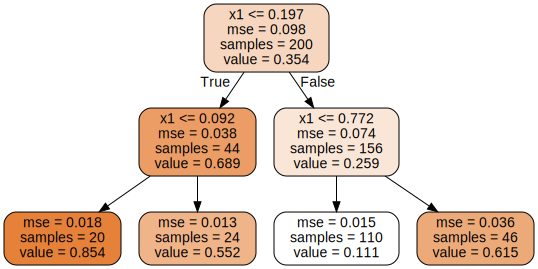

In [11]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

export_graphviz(
        tree_reg,
        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "regression_tree.dot"))

위 의사결정나무를 이용하여 예측하는 방법은 다음과 같다.
예를 들어, `x1=0.6`인 샘플이 주어졌다고 가정하자.
(하나의 특성 `x1`만 사용한다)
이제 뿌리 마디에서 출발해서 아래 과정을 따라간다.

* `x1>0.197` 이므로 오른편 아래 마디로 이동
* `x1<=0.772` 이므로 왼편 아래 마디로 이동
* 도착한 잎에 해당하는 110개의 훈련 샘플의 평균 타깃값 `value=0.111`을 예측값으로 사용

각 마디에 포함된 속성은 다음과 같다.

* `samples`: 해당 마디에 속한 훈련 샘플 수
* `value`: 해당 마디에 속한 훈련 샘플의 평균 타깃값
* `mse`: 해당 마디에 속한 훈련 샘플의 평균제곱오차(mse). 오차 기준은 `value` 사용.

앞서 생성한 2차 함수 형태의 훈련세트에 대한 비선형 회귀함수 그래프는 다음과 같이 그려진다.

* 왼편 그래프: `max_depth=2`
* 오른편 그래프: `max_depth=3`

그림 저장: tree_regression_plot


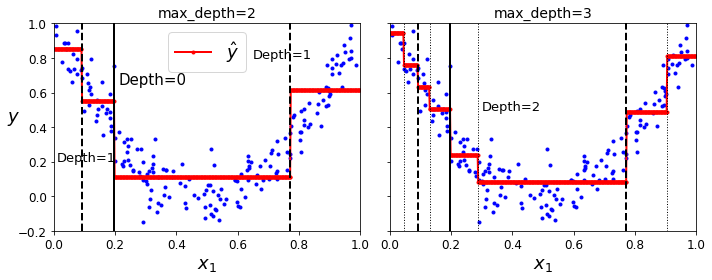

In [12]:
from sklearn.tree import DecisionTreeRegressor

# 왼편 그래프를 위한 의사결정나무 회귀 모델
tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
# 오른편 그래프를 위한 의사결정나무 회귀 모델
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

# 회귀 모델 그래프 그리는 함수
# 500개의 새로운 샘플에 대한 예측값 그리기.
def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

# 그래프 그리기
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

# 왼편 그래프 그리기
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

# 오른편 그래프 그리기
plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

save_fig("tree_regression_plot")
plt.show()

위 그래프에서 표시된 `Depth`의 의미는 다음과 같다.

* `Depth=0`
    * 실선으로된 수직선
    * $x_1 \le 0.1973$ 기준으로 분할
* `Depth=1`
    * 굵은 점선으로된 수직선 두 개
    * $x_1 \le 0.0917$ 기준으로 분할
    * $x_1 \le 0.7718$ 기준으로 분할   
* `Depth=2`
    * 옅은 점선으로된 수직선 네 개
    * $x_1 \le 0.0458$ 기준으로 분할
    * $x_1 \le 0.1298$ 기준으로 분할       
    * $x_1 \le 0.2873$ 기준으로 분할
    * $x_1 \le 0.9040$ 기준으로 분할           

### 회귀용 CART 알고리즘의 비용함수

회귀용 CART 알고리즘은 평균제곱오차(MSE)가 최소화하는 방향으로 분할을 유도하는
다음 비용함수를 활용한다. 
여기서도 탐욕적 알고리즘(greedy algorithm)을 이용하여 아래 비용함수를 최소화 하는
특성 $k$와 해당 특성의 임곗값 $t_k$을 결정한다. 

$$
J(k, t_k) = \frac{m_\text{left}}{m}\, \text{MSE}_\text{left} + \frac{m_\text{right}}{m}\, \text{MSE}_\text{right}
$$

$\text{left}$($\text{right}$) 는 분할 후 왼편(오른편) 마디를 가리키며,
각각의 경우 평균 타깃값과 편균제곱오차(mse)는 다음과 같이 계산한다.
$i\in \text{node}$는 해당 마디에 속하는 샘플을,
$y^{(i)}$는 해당 샘플의 타깃(레이블)을 가리킨다.
또한 $m_\text{node}$는 해당 마디에 속하는 샘플 수이다.

$$
\hat y_\text{node} = \frac{1}{m_\text{node}} \sum_{i\in\text{node}} y^{(i)}
\quad\quad
\text{MSE}_\text{node} = \sum_{i\in \text{node}} (\hat y_{node} - y^{(i)})^2
$$
    
아래 코드는 규제가 없는 경우와 `min_samples_leaf=10` 규제를 사용한 경우를 비교할 수 있는 
그래프르 생성한다.

* 규제가 없으면 과대적합이 발생한다.
* `min_samples_leaf=10` 규제 사용: 보다 그럴싸한 회귀 함수 생성

그림 저장: tree_regression_regularization_plot


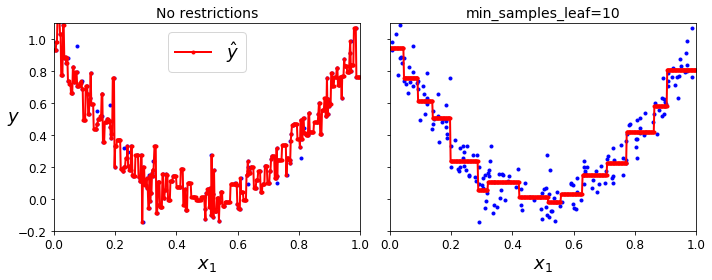

In [13]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

save_fig("tree_regression_regularization_plot")
plt.show()

## 핵심 7: 의사결정나무의 단점

의사결정나무 알고리즘은 성능이 매우 우수하지만 기본적으로 주어진 훈련 세트에 민감하게 반응하는 단점을 갖는다.

### 단점 1: 훈련 세트의 회전에 민감

의사결정나무는 항상 축에 수직인 분할을 사용한다. 
따라서 아래 두 개의 그래프가 보여주듯이 조금만 회전을 가해도 결정 경계가 많이 달라진다.

* 오른편 그래프: 왼편 그래프를 45도 회전시킨 훈련 세트 학습

그림 저장: sensitivity_to_rotation_plot


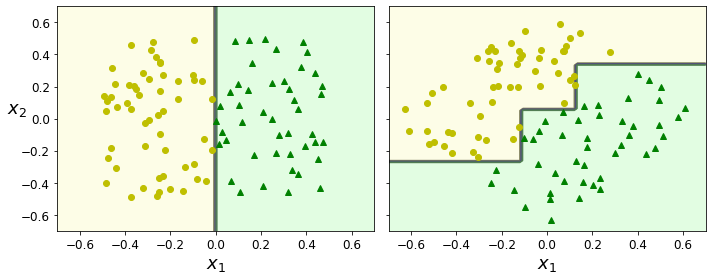

In [14]:
# 훈련 샘플을 x1, x2 모두 -0.6 ~ 0.6 구간에서 무작위로 100개 생성
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
# 타깃은 x1=0을 기준으로 분류
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

# 오른편 의사결정나무 용도로 시계방향으로 45도 회전.
angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

# 양쪽 모두 동일한 의사결정나무 알고리즘 활용. 규제 없음.
tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

# 그래프 그리기
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

# 왼편 그래프
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)

# 오른편 그래프
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)

plt.ylabel("")
save_fig("sensitivity_to_rotation_plot")
plt.show()

### 단점 2: 훈련 세트의 작은 변화에 민감

아래 코드는 붓꽃 데이터에 **하나의 샘플만을 제거**했지만
의사결정나무 그래프가 많이 달라지는 경우를 보여준다. 
먼저 붓꽃 데이터셋을 다시 가져와야 한다는 것에 주의해야 한다.
바로 앞서 `X`를 다른 데이터셋으로 지정하였기 때문이다. 

In [15]:
iris = load_iris()
X = iris.data[:, 2:] # 꽃잎 길이와 너비
y = iris.target

아래 코드는 꽃잎의 너비가 가장 큰 versicolor 꽃의 특성을 찾아준다.

* 길이: 4.8cm
* 너비: 1.8cm

In [16]:
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)]

array([[4.8, 1.8]])

이제 앞서 찾은 가장 넓은 꽃잎을 가진 데이터를 삭제한다. 

In [17]:
# 꽃잎 너비가 1.8이면 versicolor이기 때문에 타깃이 1이다.
# 따라서 파이프(|)(비트연산)을 이용하면 너비가 1.8인 경우만 False가 된다.
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)

# 너비가 1.8인 경우를 훈련 세트에서 제거한다.
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

이제 의사결정나무를 훈련시키면 이전과 많이 다른 결정 경계를 얻게 된다.

그림 저장: decision_tree_instability_plot


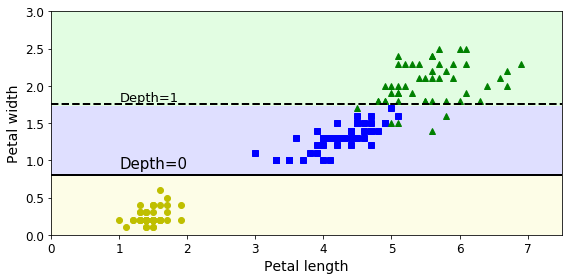

In [18]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

save_fig("decision_tree_instability_plot")
plt.show()

참고로 모든 붓꽃 데이터를 사용한 훈련 결과는 다음과 같았다.

그림 저장: decision_tree_decision_boundaries_plot


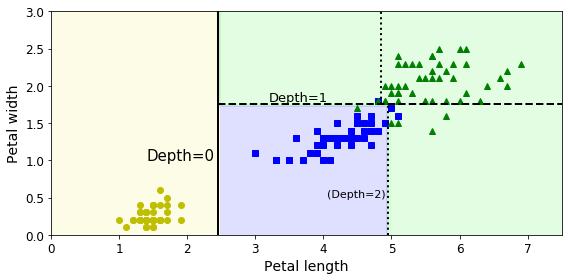

In [19]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

# 연습문제 해답

## 1. to 6.

부록 A 참조.

## 7.

_문제: moons 데이터셋에 의사결정나무를 훈련시키고 세밀하게 튜닝해보세요._

a. `make_moons(n_samples=1000, noise=0.4)`를 사용해 데이터셋을 생성합니다.

`random_state=42`를 지정하여 결과를 일정하게 만듭니다:

In [20]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

b. 이를 `train_test_split()`을 사용해 훈련 세트와 테스트 세트로 나눕니다

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

c. `DecisionTreeClassifier`의 최적의 매개변수를 찾기 위해 교차 검증과 함께 그리드 탐색을 수행합니다(`GridSearchCV`를 사용하면 됩니다). 힌트: 여러 가지 `max_leaf_nodes` 값을 시도해보세요.

In [22]:
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed:    5.0s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16

In [23]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=17,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

d. 찾은 매개변수를 사용해 전체 훈련 세트에 대해 모델을 훈련시키고 테스트 세트에서 성능을 측정합니다. 대략 85~87%의 정확도가 나올 것입니다.

기본적으로 `GridSearchCV`는 전체 훈련 세트로 찾은 최적의 모델을 다시 훈련시킵니다(`refit=False`로 지정해서 바꿀 수 있습니다). 그래서 별도로 작업할 필요가 없습니다. 모델의 정확도를 바로 평가할 수 있습니다:

In [24]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8695

## 8.

_문제: 랜덤 포레스트를 만들어보세요._

a. 이전 연습문제에 이어서, 훈련 세트의 서브셋을 1,000개 생성합니다. 각각은 무작위로 선택된 100개의 샘플을 담고 있습니다. 힌트: 사이킷런의 `ShuffleSplit`을 사용할 수 있습니다.

In [25]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

b. 앞에서 찾은 최적의 매개변수를 사용해 각 서브셋에 의사결정나무를 훈련시킵니다. 테스트 세트로 이 1,000개의 의사결정나무를 평가합니다. 더 작은 데이터셋에서 훈련되었기 때문에 이 의사결정나무는 앞서 만든 의사결정나무보다 성능이 떨어져 약 80%의 정확도를 냅니다.

In [26]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.8054499999999999

c. 이제 마술을 부릴 차례입니다. 각 테스트 세트 샘플에 대해 1,000개의 의사결정나무 예측을 만들고 다수로 나온 예측만 취합니다(사이파이의 `mode()` 함수를 사용할 수 있습니다). 그러면 테스트 세트에 대한 _다수결 예측_이 만들어집니다.

In [27]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [28]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

d. 테스트 세트에서 이 예측을 평가합니다. 앞서 만든 모델보다 조금 높은(약 0.5~1.5% 정도) 정확도를 얻게 될 것입니다. 축하합니다. 랜덤 포레스트 분류기를 훈련시켰습니다!

In [29]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872